<a href="https://colab.research.google.com/github/lwa01/229352-STAT-LEARING-FOR-DATA-SCI-2/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

[Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)

In [66]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [67]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [68]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [69]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [70]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [71]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [72]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

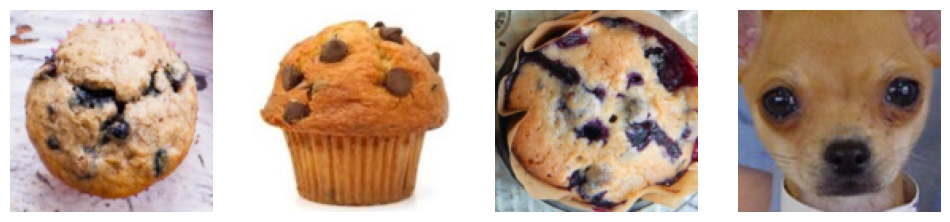

tensor([1, 1, 1, 0])


In [73]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [74]:
class SimpleLogisticRegression(nn.Module): # Model class
  # Attribute --> Layers
  def __init__(self):
    super().__init__()
    # Define Layers
    self.flatten = nn.Flatten() # คลี่รูปภาพ
    # Linear Layers
    self.lin1 = nn.Linear(128 * 128 * 3, 100) # input ตัวที่สองมีความยาว 100
    self.act1 = nn.ReLU() # Activation function
    self.lin2 = nn.Linear(100, 50)
    self.act2 = nn.ReLU() # Activation function
    self.lin3 = nn.Linear(50, 1)

  # init เชื่อมต่อกันอย่างไรบ้าง
  def forward(self, x):
  # Forward pass ข้อมูลผ่านตรงไหนบ้าง
    x = self.flatten(x)
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [75]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [76]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [77]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [78]:
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [79]:
X, y = next(train_batches) # X : images, y : labels

#### Make a prediction on the minibatch (Forward pass)

In [80]:
y_hat = model(X)
y = y.to(torch.float32)
# Output ---> vector ---> Scalar
y_hat = y_hat[:, 0]

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [81]:
# Compute the loss
train_loss = criterion(y_hat, y)
train_losses.append(train_loss)

In [82]:
train_losses

[tensor(9.2103, grad_fn=<DivBackward1>)]

#### Calculate the gradient (Backward pass)

In [83]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
train_loss.backward()

In [84]:
model.parameters()

<generator object Module.parameters at 0x79c746af2180>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [85]:
# Update the weights using the gradient descent rule
optimizer.step() # parameter - learning_rate

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [86]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    print(y_hat, y)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010]) tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 0., 1., 1.])


In [87]:
print(train_losses)
print(val_losses)

[tensor(9.2103, grad_fn=<DivBackward1>)]
[34.95859146118164]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

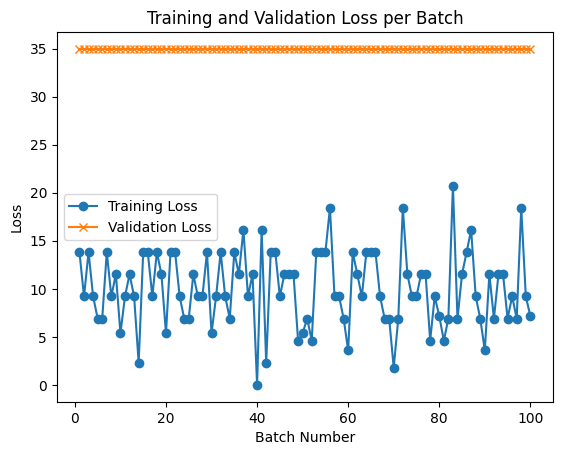

In [88]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [89]:
#  1. Create a neural network with 3 hidden layers
class DeepNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        # 3 hidden layers: 128 → 64 → 32
        self.fc1 = nn.Linear(3*128*128, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)

        # Output layer (2 classes for CrossEntropyLoss)
        self.fc4 = nn.Linear(32, 2)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [90]:
# 2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]

for lr in learning_rates:

    print(f"\nTraining with learning rate = {lr}")

    model = DeepNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(10):

        running_loss = 0.0

        for X, y in train_loader:

            outputs = model(X)
            loss = criterion(outputs, y)

            loss.backward()
            optimizer.step()
            model.zero_grad()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Training with learning rate = 0.01
Epoch 1, Loss: 12.485783380270004
Epoch 2, Loss: 5.134816890954971
Epoch 3, Loss: 0.8437155842781067
Epoch 4, Loss: 0.7853282690048218
Epoch 5, Loss: 0.48452405631542206
Epoch 6, Loss: 0.4030716523528099
Epoch 7, Loss: 0.3097815901041031
Epoch 8, Loss: 0.5996014460921287
Epoch 9, Loss: 0.38197421431541445
Epoch 10, Loss: 0.2593073551543057

Training with learning rate = 0.001
Epoch 1, Loss: 1.1274689257144928
Epoch 2, Loss: 0.6251265347003937
Epoch 3, Loss: 0.7163839787244797
Epoch 4, Loss: 0.56709004342556
Epoch 5, Loss: 0.4859496235847473
Epoch 6, Loss: 0.3549600809812546
Epoch 7, Loss: 0.35455590337514875
Epoch 8, Loss: 0.2405218869447708
Epoch 9, Loss: 0.22786744870245457
Epoch 10, Loss: 0.14322893396019937

Training with learning rate = 0.0001
Epoch 1, Loss: 0.6967218518257141
Epoch 2, Loss: 0.6573916614055634
Epoch 3, Loss: 0.6281055569648742
Epoch 4, Loss: 0.6111078143119812
Epoch 5, Loss: 0.5874784320592881
Epoch 6, Loss: 0.48459618389606474


2.1 What value of learning rate do you think is the best? Please explain your reason.

: The best learning rate is 1e-4 (0.0001) because from the experiment it gives the lowest final training loss (around 0.25) compared to the other values. The loss also decreases smoothly without large fluctuations. Although 1e-3 also performs well, its final loss is slightly higher. In contrast, 0.01 starts with a very high loss, and 1e-5 decreases too slowly.

2.2 What happens to the training losses if your learning rate is too large?

: If the learning rate is too large, such as 0.01, the training loss becomes unstable. From the result, the loss starts at a very high value (around 6.20), which shows that the weight updates are too large. This can cause the model to overshoot the optimal point and make the training process unstable.

2.3 What happens to the training losses if your learning rate is too small?

: If the learning rate is too small, such as 1e-5, the training loss decreases very slowly. From the experiment, after 10 epochs the loss is still around 0.56, which shows that the model learns slowly and needs more epochs to improve.

In [91]:
# 3. After finish training your model. Make the predictions on the test set and compute the accuracy.
model.eval()

with torch.no_grad():
    test_batches = iter(test_loader)
    X, y = next(test_batches)

    outputs = model(X)
    _, preds = torch.max(outputs, 1)

    accuracy = (preds == y).float().mean()
    print("Test Accuracy:", accuracy.item())

Test Accuracy: 0.699999988079071


In [92]:
# 4. Use plt.imshow() to display at least four images that are incorrectly classified by this model.
wrong_images = []
wrong_preds = []
wrong_labels = []

model.eval()

with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X)
        _, preds = torch.max(outputs, 1)

        for i in range(len(y)):
            if preds[i] != y[i]:
                wrong_images.append(X[i])
                wrong_preds.append(preds[i])
                wrong_labels.append(y[i])

            if len(wrong_images) >= 4:
                break

        if len(wrong_images) >= 4:
            break

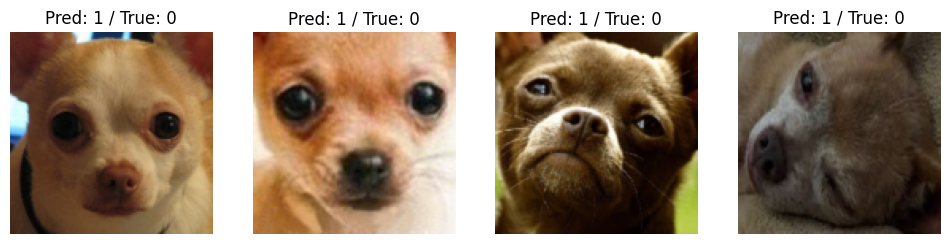

In [93]:
plt.figure(figsize=(12,4))

for i in range(4):
    img = wrong_images[i].numpy().transpose(1,2,0)
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {int(wrong_preds[i])} / True: {int(wrong_labels[i])}")
    plt.axis("off")

plt.show()